<a href="https://colab.research.google.com/github/Azhar-Sharif/Data-Visualization/blob/main/site/en/hub/tutorials/yamnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:

!pip install tensorflow tensorflow_hub numpy scipy torch speechbrain ipython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00


##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [31]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/yamnet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/yamnet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/yamnet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/yamnet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Sound classification with YAMNet

YAMNet is a deep net that predicts 521 audio event [classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv) from the [AudioSet-YouTube corpus](http://g.co/audioset) it was trained on. It employs the
[Mobilenet_v1](https://arxiv.org/pdf/1704.04861.pdf) depthwise-separable
convolution architecture.

In [32]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

Load the Model from TensorFlow Hub.

Note: to read the documentation just follow the model's [url](https://tfhub.dev/google/yamnet/1)

In [33]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

The labels file will be loaded from the models assets and is present at `model.class_map_path()`.
You will load it on the `class_names` variable.

In [34]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

Add a method to verify and convert a loaded audio is on the proper sample_rate (16K), otherwise it would affect the model's results.

In [35]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

## Downloading and preparing the sound file

Here you will download a wav file and listen to it.
If you have a file already available, just upload it to colab and use it instead.

Note: The expected audio file should be a mono wav file at 16kHz sample rate.

In [36]:
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0   165k      0 --:--:-- --:--:-- --:--:--  165k


In [37]:
!curl -O https://storage.googleapis.com/audioset/miaow_16k.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  210k  100  210k    0     0   133k      0  0:00:01  0:00:01 --:--:--  133k


In [49]:
#wav_file_name = 'speech_whistling2.wav'
wav_file_name = 'miaow_16k.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 6.73s
Size of the input: 107698


<ipython-input-49-f39d76d26634>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')


The `wav_data` needs to be normalized to values in `[-1.0, 1.0]` (as stated in the model's [documentation](https://tfhub.dev/google/yamnet/1)).

In [39]:
waveform = wav_data / tf.int16.max

## Executing the Model

Now the easy part: using the data already prepared, you just call the model and get the: scores, embedding and the spectrogram.

The score is the main result you will use.
The spectrogram you will use to do some visualizations later.

In [40]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [41]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Whistle


## Visualization

YAMNet also returns some additional information that we can use for visualization.
Let's take a look on the Waveform, spectrogram and the top classes inferred.

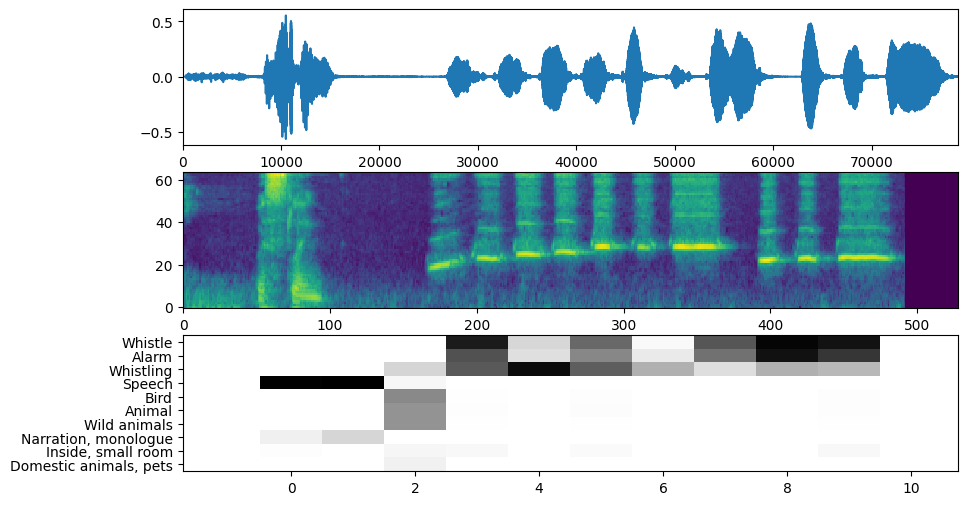

In [42]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

# **THis is the Complete pipeline of Our speech Denoising project**

In [50]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import scipy
import torch
from speechbrain.pretrained import SepformerSeparation
from scipy.io import wavfile
from IPython.display import Audio
import csv

# 1. Load the YAMNet model for noise classification from TensorFlow Hub
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Function to classify noise type using YAMNet
def classify_noise(file_path):
    # Read the audio file
    sample_rate, wav_data = wavfile.read(file_path)
    wav_data = wav_data / tf.int16.max  # Normalize the audio

    # Run the model
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    scores_np = scores.numpy()

    # Get the class names from YAMNet's CSV file
    class_map_path = yamnet_model.class_map_path().numpy()
    def class_names_from_csv(class_map_csv_text):
        class_names = []
        with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                class_names.append(row['display_name'])
        return class_names

    class_names = class_names_from_csv(class_map_path)

    # Find the class with the highest score
    inferred_class = class_names[scores_np.mean(axis=0).argmax()]

    return inferred_class

# 2. Denoise the audio based on the classified noise type
def denoise_audio(noise_type, file_path):
    # Load the SepformerSeparation model for denoising
    sepformer_model = SepformerSeparation.from_hparams(source="speechbrain/sepformer-dns4-16k-enhancement")

    # Apply denoising based on noise type
    if noise_type == "air_conditioner":
        print("Applying denoising for air_conditioner...")
        # Denoise with specific model for air_conditioner if available, otherwise use general denoising
        est_sources = sepformer_model.separate_file(file_path)
    elif noise_type == "car_horn":
        print("Applying denoising for car_horn...")
        # Apply car_horn specific denoising model here
        est_sources = sepformer_model.separate_file(file_path)
    else:
        print(f"Applying general denoising for {noise_type}...")
        est_sources = sepformer_model.separate_file(file_path)

    # Access the enhanced audio (first separated source, assume it is the enhanced speech)
    enhanced_audio = est_sources[:, :, 0].detach().cpu().numpy()

    return enhanced_audio

# Main function to run the full workflow
def process_audio(file_path):
    # Step 1: Classify the noise type
    noise_type = classify_noise(file_path)
    print(f"Classified noise type: {noise_type}")

    # Step 2: Apply denoising based on the classified noise type
    enhanced_audio = denoise_audio(noise_type, file_path)

    # Print the shape of the enhanced audio
    print(f"Enhanced audio shape: {enhanced_audio.shape}")

    # Optionally play the enhanced audio
    # To play audio in Jupyter/Colab, use the following line
    clear_audio = Audio(enhanced_audio, rate=16000)  # Assuming original sample rate is 16000 Hz
    return clear_audio
# Example usage
file_path = "speech_whistling2.wav"  # Replace with your audio file path
process_audio(file_path)


Classified noise type: Whistle
Applying general denoising for Whistle...
Enhanced audio shape: (1, 78720)
